In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [3]:
INPUT_PATH = "images/"
EMOTIONS = ["angry", "sad", "happy"]

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS:
        count = 0
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            count += 1
            total_images += 1
        print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

angry has 2256 number of images
sad has 4532 number of images
happy has 4784 number of images

total images are 11572


In [4]:
img_arr = np.empty(shape=(total_images, 96, 96, 3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_resized = cv2.resize(img, (96, 96))
            img_arr[i] = img_resized
            img_label[i] = e
            i += 1
        e += 1

img_arr.shape, img_label.shape

((11572, 96, 96, 3), (11572,))

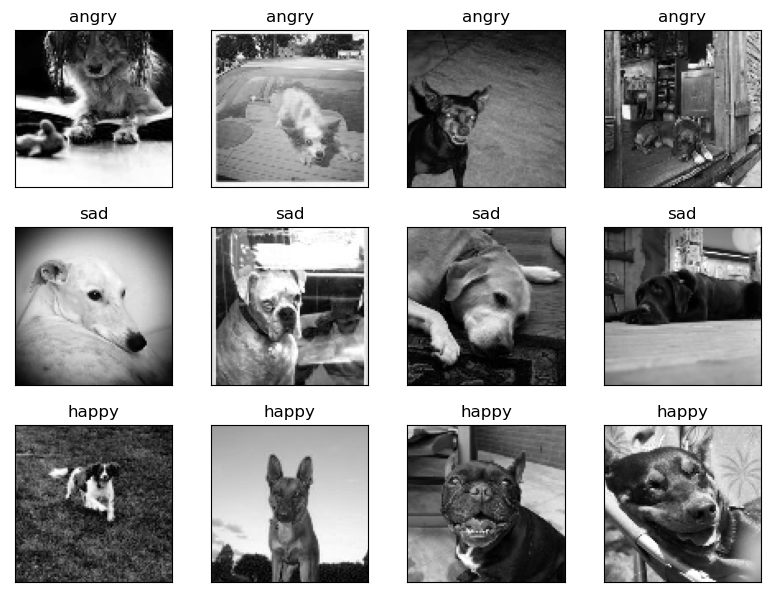

In [5]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [6]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(11572, 3)

In [7]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, shuffle = True, stratify = img_label, train_size = 0.9, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10414, 96, 96, 3), (1158, 96, 96, 3), (10414, 3), (1158, 3))

In [8]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [9]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name = "global_pool")(x)
out = Dense(num_classes, activation = "softmax", name = "out_layer")(global_pool)

model = Model(inputs = mobile_net.input, outputs = out)

for layer in model.layers[:15]:
    layer.trainable = False

17225924/17225924 [==============================] - 1s 0us/step


In [10]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    zca_whitening = False,
)
train_datagen.fit(X_train)

In [11]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.00008,
    patience = 11,
    verbose = 1,
    restore_best_weights = True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    min_delta = 0.0001,
    factor = 0.25,
    patience = 4,
    min_lr = 1e-7,
    verbose = 1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
batch_size = 25
epochs = 100

optim = optimizers.Nadam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)

model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optim,
        metrics = ['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing=True
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
416/416 [==============================] - 59s 89ms/step - loss: 1.1107 - accuracy: 0.5356 - val_loss: 1.1452 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/100
416/416 [==============================] - 36s 86ms/step - loss: 0.9094 - accuracy: 0.6009 - val_loss: 0.8738 - val_accuracy: 0.6218 - lr: 0.0010
Epoch 3/100
416/416 [==============================] - 35s 84ms/step - loss: 0.8642 - accuracy: 0.6201 - val_loss: 0.8879 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 4/100
416/416 [==============================] - 37s 87ms/step - loss: 0.8305 - accuracy: 0.6403 - val_loss: 0.8571 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 5/100
416/416 [==============================] - 35s 85ms/step - loss: 0.8128 - accuracy: 0.6538 - val_loss: 0.8768 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 6/100
416/416 [==============================] - 36s 86ms/step - loss: 0.7919 - accuracy: 0.6603 - val_loss: 0.8766 - val_accuracy: 0.6054 - lr: 0.0010
Epoch 7/100
416/416 [==============================]

In [20]:
model.save("dog_emotion_model.h5")